In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import pandas as pd

In [4]:
import GPy

In [5]:
import sys
sys.path.insert(0, '../source')

In [6]:
from incremental_run import Data, loadData, compute_several_stats, RunFullGP, RunPoE, RunSparseGP

In [7]:
from CPoE import CPoE

## load toy data example used in the CPoE paper

In [8]:
path = 'datasets/deepMixtureGP/'
y_train = np.genfromtxt( path+"y_train.csv",  delimiter=',')
X_train = np.genfromtxt( path+"X_train.csv",  delimiter=',')[:,None]
X_test = np.genfromtxt( path+"X_test.csv",  delimiter=',')[:,None]

In [9]:
DD = Data(X_train.shape[0], X_test.shape[0])
DD.X_train = X_train
DD.y_train = y_train
DD.X_test = X_test
DD.y_test = np.zeros( X_test.shape[0] )
DD.D = 1

In [10]:
kernG = GPy.kern.RBF(input_dim = 1, variance = 1.1, lengthscale = 0.1 )

In [11]:
likG = GPy.likelihoods.Gaussian(variance=0.3)

In [12]:
# run full GP 
rFullGP = RunFullGP(DD, kernG, likelihood=likG ).run()

In [13]:
# run CPoE algorithm with J=6, C=2, gamma=1
RES1, MOD1 = CPoE(DD.X_train, DD.y_train, kernG, likG, 6, 2, 1, y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test)
ST_CPoE = compute_several_stats( [RES1], mFull=rFullGP.m, vFull=rFullGP.v)

In [14]:
# comparison with independent PoE methods
namsePoE = np.array(['minVar', 'GPoE-scaled','BCM'])
argsPartPoE = {'KMEANS':False, 'sortDim':0}
rPoE = RunPoE(DD, 6, kernG, likG,  **argsPartPoE)
runsPoE = [rPoE.run(nam) for nam in namsePoE]
ST_PoE = compute_several_stats(runsPoE, rFullGP.m, rFullGP.v)

6.461143493652344e-05


In [15]:
# comparison with gloabl inducing point method with M=25
runsSparse = RunSparseGP(DD, kernG, 25, likelihood=likG, seed=78).run(OPT_TH=False) 
ST_SPARSE = compute_several_stats([runsSparse], rFullGP.m, rFullGP.v)

nothing to optimize


In [16]:
# show statistics
DF = pd.concat( [ST_CPoE, ST_PoE, ST_SPARSE])
DF

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov
CPoE(2),0.063,-72.377,0.081,0.010,0.585,1.005,0.768,3.561,0.785
minVar,0.076,-74.207,7.624,0.087,0.595,1.015,0.791,3.569,0.782
GPoE-scaled,0.053,-74.207,10.429,0.080,0.562,0.971,0.741,3.273,0.797
BCM,0.052,-74.207,10.061,0.068,0.578,0.999,0.745,3.649,0.790
sparse25,0.270,-73.581,6.743,0.074,0.578,0.994,0.747,3.558,0.784


In [17]:
# load results from DeepStructureMixture GP 
# (as computed in the julia notebook comparisonDeepStructuredMixture_jl.ipynb)

In [18]:
MS1 = np.genfromtxt( path+"ms_deepStructMix_mixture.csv",  delimiter=',')
argsXt = np.argsort(DD.X_test[:,0])
CI_add1 = 1.9*np.sqrt(MS1[argsXt,1])
mm1 = MS1[argsXt,0]

In [19]:
def KL1(m1,m2,v1,v2):
    return 0.5*(np.log(v2/v1) + (v1 + (m1-m2)**2)/v2 - 1)  

In [20]:
KL_DSM = np.mean( KL1(rFullGP.m[argsXt], mm1, rFullGP.v[argsXt], MS1[argsXt,1]) )*1000

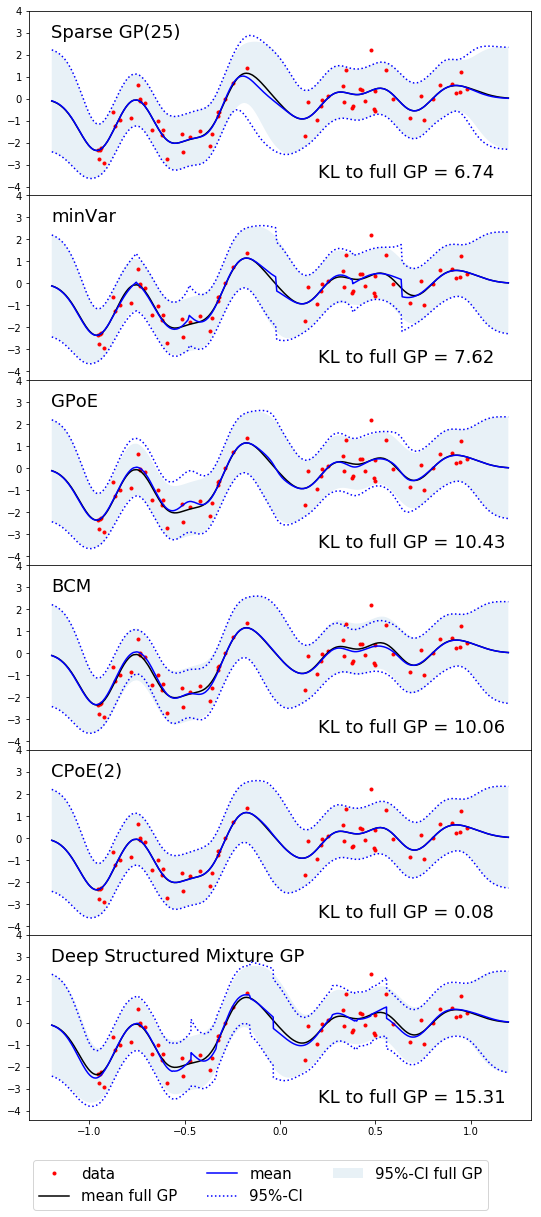

In [21]:
figS = (9,3.4)
nP = 6

#limits
y1 = -4.4
y2 = 4


#text title
yt1 = -1.2
yt2 = 2.8

#text title
ytt1 = 0.2
ytt2 = -3.6

ms = 6
ms2 = 7

argsXt = np.argsort(DD.X_test[:,0])
Xtsort = DD.X_test[argsXt,0]

kk = 1

titles = ['Sparse GP(25)','minVar','GPoE','BCM','CPoE(2)','Deep Structured Mixture GP']

KLs = np.hstack([DF['KLx1000'][[4,1,2,3,0]],KL_DSM])

run = [runsSparse,*runsPoE,RES1 ]

f, axs = plt.subplots(nP,1, sharex=True, sharey=False, figsize=(figS[0]*1,nP*figS[1]))
f.subplots_adjust(hspace=0., wspace=0.1)

for i,ax in enumerate(axs):
    
    # data
    ax.plot(DD.X_train[:,0], DD.y_train, 'r.', markersize=ms, label='data')
    
    # full GP
    ax.plot(Xtsort, rFullGP.m[argsXt], 'k-',label='mean full GP')
    ax.fill_between(Xtsort, rFullGP.CI[argsXt,0], rFullGP.CI[argsXt,1], alpha= 0.1, label='95%-CI full GP')
    
    # approx GP
    if i<5:
        ax.plot(Xtsort, run[i].m[argsXt], 'b-')
        ax.plot(Xtsort, run[i].CI[argsXt,0], 'b:')
        ax.plot(Xtsort, run[i].CI[argsXt,1], 'b:')
    elif i==5:
        ax.plot(Xtsort, mm1, 'b-',label='mean')
        ax.plot(Xtsort, mm1 + CI_add1, 'b:',label='95%-CI')
        ax.plot(Xtsort, mm1 - CI_add1, 'b:')

    
    # set title and limit
    ax.text(yt1,yt2,titles[i], fontsize=18)
    ax.text(ytt1,ytt2,'KL to full GP = '+str(np.round(KLs[i],2)), fontsize=18)
    ax.set_ylim(y1,y2); 

ax.legend(bbox_to_anchor=(.93, -0.18), ncol=3, fontsize=15);

## load toy data used in deepMixtureGP paper

This example is based on [https://github.com/trappmartin/DeepStructuredMixtures](https://github.com/trappmartin/DeepStructuredMixtures).

In [22]:
# load training data
YX = np.genfromtxt( path+"ms_deepStructMix_trainingYX.csv",  delimiter=',')

# load predicted mean and variance from deepMixtureGP
# (as computed in the julia notebook comparisonDSM_jl.ipynb)
MS = np.genfromtxt( path+"ms_deepStructMix.csv",  delimiter=',')
CI_addNew = 1.96*np.sqrt(MS[:,1])
mmNew = MS[:,0]

In [23]:
# consturct dataset
DD = Data(YX.shape[0], MS.shape[0])
DD.X_train = YX[:,1][:,None]
DD.y_train = YX[:,0]
DD.X_test = MS[:,2][:,None]

DD.y_test = MS[:,2]*0
DD.D = 1

In [24]:
# load hyperparameters from deepMixtureGP and consturct same kernel and likelihood

In [25]:
hypers = np.genfromtxt( path+"ms_deepStructMix_hypers.csv",  delimiter=',')
kernG = GPy.kern.RBF(input_dim = 1, variance = hypers[0]**2, lengthscale = hypers[1], ARD = True)
likG = GPy.likelihoods.Gaussian(variance=hypers[2]**2)

In [26]:
# run full GP 
rFullGP = RunFullGP(DD, kernG, likelihood=likG ).run()

In [27]:
# run CPoE algorithm with J=5, C=2, gamma=1
RES1, MOD1 = CPoE(DD.X_train, DD.y_train, kernG, likG, 5, 2, 1, y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test, seed=0)
ST_CPoE = compute_several_stats( [RES1], mFull=rFullGP.m, vFull=rFullGP.v)

In [28]:
# comparison with independent PoE methods
namsePoE = np.array(['minVar', 'GPoE-scaled','BCM'])
argsPartPoE = {'KMEANS':False, 'sortDim':0}
rPoE = RunPoE(DD, 5, kernG, likG,  **argsPartPoE)
runsPoE = [rPoE.run(nam) for nam in namsePoE]
ST_PoE = compute_several_stats(runsPoE, rFullGP.m, rFullGP.v)

0.0054280757904052734


In [29]:
## comparison with gloabl inducing point method with M=20
runsSparse = RunSparseGP(DD, kernG, 20, likelihood=likG, seed=78).run(OPT_TH=False) 
ST_SPARSE = compute_several_stats([runsSparse], rFullGP.m, rFullGP.v)

nothing to optimize


In [30]:
# show statistics
DF = pd.concat( [ST_CPoE, ST_PoE, ST_SPARSE])
DF

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov
CPoE(2),0.036,4.156,3.677,0.024,0.544,0.754,0.652,11.729,0.290
minVar,0.081,-15.173,30.780,0.047,0.533,0.742,0.642,10.980,0.294
GPoE-scaled,0.081,-15.173,116.976,0.062,0.532,0.767,0.665,6.964,0.370
BCM,0.081,-15.173,84.511,0.081,0.565,0.765,0.664,15.973,0.276
sparse20,0.344,5.331,5.478,0.029,0.546,0.752,0.653,12.133,0.290


In [31]:
# load results from DeepStructureMixture GP 
# (as computed in the julia notebook comparisonDeepStructuredMixture_jl.ipynb)

In [32]:
argsXt = np.argsort(DD.X_test[:,0])
CI_add1 = 1.9*np.sqrt(MS[argsXt,1])
mm1 = MS[argsXt,0]

In [33]:
KL_DSM = np.mean( KL1(rFullGP.m[argsXt], mm1, rFullGP.v[argsXt], MS[argsXt,1]) )*1000

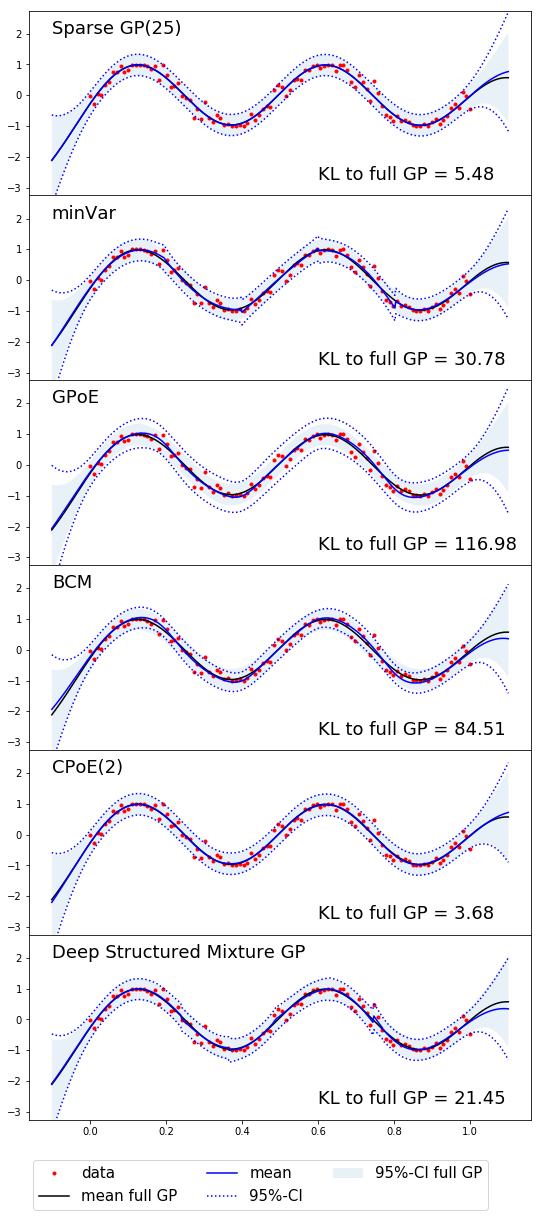

In [34]:
figS = (9,3.4)
nP = 6


yt1_A = -0.1
ytt1_A = 0.6
y1_A = -3.25
y2_A = 2.75
ytt2_A = -2.75
yt2_A = 2


ms = 6
ms2 = 7

argsXt = np.argsort(DD.X_test[:,0])
Xtsort = DD.X_test[argsXt,0]

kk = 1

titles = ['Sparse GP(25)','minVar','GPoE','BCM','CPoE(2)','Deep Structured Mixture GP']

KLs = np.hstack([DF['KLx1000'][[4,1,2,3,0]],KL_DSM])

run = [runsSparse,*runsPoE,RES1 ]

f, axs = plt.subplots(nP,1, sharex=True, sharey=False, figsize=(figS[0]*1,nP*figS[1]))
f.subplots_adjust(hspace=0., wspace=0.1)

for i,ax in enumerate(axs):
    
    # data
    ax.plot(DD.X_train[:,0], DD.y_train, 'r.', markersize=ms, label='data')
    
    # full GP
    ax.plot(Xtsort, rFullGP.m[argsXt], 'k-',label='mean full GP')
    ax.fill_between(Xtsort, rFullGP.CI[argsXt,0], rFullGP.CI[argsXt,1], alpha= 0.1, label='95%-CI full GP')
    
    # approx GP
    if i<5:
        ax.plot(Xtsort, run[i].m[argsXt], 'b-')
        ax.plot(Xtsort, run[i].CI[argsXt,0], 'b:')
        ax.plot(Xtsort, run[i].CI[argsXt,1], 'b:')
    elif i==5:
        ax.plot(Xtsort, mm1, 'b-',label='mean')
        ax.plot(Xtsort, mm1 + CI_add1, 'b:',label='95%-CI')
        ax.plot(Xtsort, mm1 - CI_add1, 'b:')

    
    # set title and limit
    ax.text(yt1_A,yt2_A,titles[i], fontsize=18)
    ax.text(ytt1_A,ytt2_A,'KL to full GP = '+str(np.round(KLs[i],2)), fontsize=18)
    ax.set_ylim(y1_A,y2_A); 
    
    


ax.legend(bbox_to_anchor=(.93, -0.18), ncol=3, fontsize=15);